In [1]:
%load_ext autoreload
%autoreload 2
import numpy
from matplotlib import pyplot
import sys
sys.path.append('../../timeseries/')
sys.path.append('../../src/')
import observation_models
import state_models
from ssm_em import StateSpaceEM

# Generate some data 

In [2]:
T = 1000
trange = numpy.arange(T)
Dx = 2
Dz = 2
X = numpy.empty((T,Dx))
X[:,0] = numpy.sin(trange / 20)
X[:,1] = numpy.sin(trange / 10)
noise_x = .2
noise_z = .1
X += noise_x * numpy.random.randn(*X.shape)

# Linear state space model 

In [3]:
sm = state_models.LinearStateModel(Dz, noise_z)
om = observation_models.LinearObservationModel(Dx, Dz, noise_x)
om.pca_init(X)

In [4]:
ssm_em = StateSpaceEM(X, observation_model=om, state_model=sm)

Iteration 10 - llk=-130.0
Iteration 20 - llk=-129.4
EM did converge.


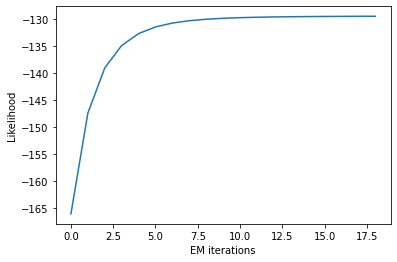

In [5]:
ssm_em.run()
pyplot.plot(ssm_em.llk_list[1:])
pyplot.xlabel('EM iterations')
pyplot.ylabel('Likelihood')
pyplot.show()

Text(0.5, 0, 'Time steps')

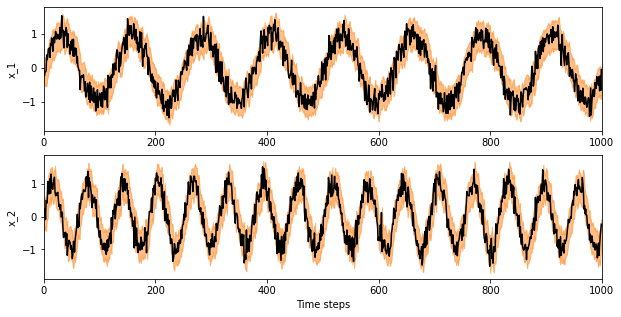

In [6]:
p_x = ssm_em.compute_data_density()
pyplot.figure(figsize=(10,5))
for ix in range(Dx):
    pyplot.subplot(Dx,1,ix+1)
    x_min = p_x.mu[:,ix] - 1.68 * numpy.sqrt(p_x.Sigma[:,ix,ix])
    x_max = p_x.mu[:,ix] + 1.68 * numpy.sqrt(p_x.Sigma[:,ix,ix])
    pyplot.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5)
    pyplot.plot(X[:,ix],'k')
    pyplot.ylabel('x_%d' %(ix+1))
    pyplot.xlim([0,X.shape[0]])
pyplot.xlabel('Time steps')

# State space model with non linear transition mean

In [28]:
Dk = 10
sm = state_models.LSEMStateModel(Dz, Dk, noise_z)
om = observation_models.LinearObservationModel(Dx, Dz, noise_x)
om.pca_init(X)

In [29]:
ssm_em = StateSpaceEM(X, observation_model=om, state_model=sm)

Iteration 10 - llk=-145.8
EM did converge.


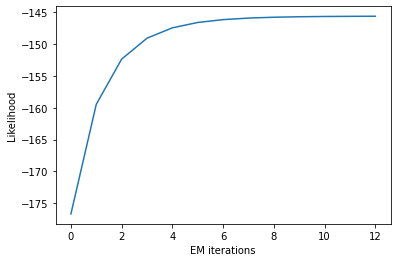

In [30]:
ssm_em.run()
pyplot.plot(ssm_em.llk_list[1:])
pyplot.xlabel('EM iterations')
pyplot.ylabel('Likelihood')
pyplot.show()

Text(0.5, 0, 'Time steps')

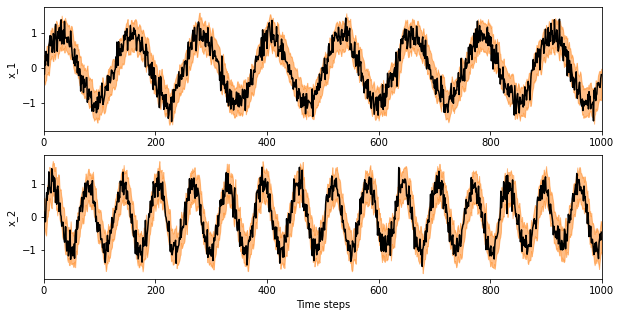

In [31]:
p_x = ssm_em.compute_data_density()
pyplot.figure(figsize=(10,5))
for ix in range(Dx):
    pyplot.subplot(Dx,1,ix+1)
    x_min = p_x.mu[:,ix] - 1.68 * numpy.sqrt(p_x.Sigma[:,ix,ix])
    x_max = p_x.mu[:,ix] + 1.68 * numpy.sqrt(p_x.Sigma[:,ix,ix])
    pyplot.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5)
    pyplot.plot(X[:,ix],'k')
    pyplot.ylabel('x_%d' %(ix+1))
    pyplot.xlim([0,X.shape[0]])
pyplot.xlabel('Time steps')